# Raport z Snake'a

# Część przygotowawcza

## Import koniecznych bibliotek

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Wczytanie danych

In [6]:
stats_dir = '../stats'

human_30x30 = pd.read_csv(f'{stats_dir}/snake-human-30x30.csv')
human_5x5 = pd.read_csv(f'{stats_dir}/snake-human-5x5.csv')

default_30x30 = pd.read_csv(f'{stats_dir}/snake-default-30x30.csv')
default_5x5 = pd.read_csv(f'{stats_dir}/snake-default-5x5.csv')
default_30x30_long_tail = pd.read_csv(f'{stats_dir}/snake-default-30x30-long-tail.csv')
default_5x5_on_30x30 = pd.read_csv(f'{stats_dir}/snake-default-5x5-on-30x30.csv')

## Stworzenie funkcji

In [7]:
def get_finished_games(df):
    """Usuwa wszystkie gry, które nie zostały zakończone."""
    df = df.copy()
    df = df[df['czy_koniec'] == True]

    df.reset_index(drop=True, inplace=True)
    return df

In [8]:
def get_last_percent_of_records(df, percent):
    """Zwraca ostatni procent rekordów z DataFrame."""
    df = df.copy()
    n = int(len(df) * percent)
    return df.iloc[-n:]

In [9]:
def compare_stats(dfs, labels, is_last_human=False):
    df = pd.DataFrame()

    for i in range(len(dfs) - int(is_last_human)):
        finished = get_finished_games(dfs[i])
        last10percent = get_last_percent_of_records(finished, 0.1)
        df[labels[i]] = last10percent['wynik'].describe()
    # Ponieważ człowiek rozegrał o wiele mniej gier, uwzględnij wszystkie jego gry
    if is_last_human: df[labels[-1]] = get_finished_games(dfs[-1])['wynik'].describe()
    return df

In [17]:
def plot_score_increase(dfs, labels):
    """Rysuje wykresy wzrostu wyników w kolejnych rundach."""

    fig, ax = plt.subplots(figsize=(12, 8))
    for i in range(len(dfs)):
        finished = get_finished_games(dfs[i]).copy()

        finished.loc[0, 'suma'] = finished.at[0, 'wynik']
        finished.loc[0, 'średnia'] = finished.at[0, 'suma']


        for i2 in range(1, len(finished)):
            finished.at[i2, 'suma'] = finished.at[i2-1, 'suma'] + finished.at[i2, 'wynik']
            finished.at[i2, 'średnia'] = finished.at[i2, 'suma'] / (i2 + 1)

        ax.plot (finished['runda'], finished['średnia'], label=labels[i])

    ax.set_xlabel('Runda')
    ax.set_ylabel('Średni wynik')
    ax.legend()
    return fig, ax

# Analiza wyników

## Plansza 5x5

## Wyniki
Poniższa tabela przedstawia średnie i mediany wyników uzyskane przez wytrenowanych agentów (10% ostatnich gier) i człowieka.

In [11]:
compare_stats([default_5x5, human_5x5], ['Agent domyślny', 'Człowiek'], is_last_human=True)

,Agent domyślny,Człowiek
count,120.000000,14.000000
mean,57.000000,35.000000
std,37.430047,48.158393
min,0.000000,-10.000000
25%,30.000000,-10.000000
50%,60.000000,15.000000
75%,72.500000,90.000000
max,200.000000,100.000000


#### Wykres wzrostu wyników

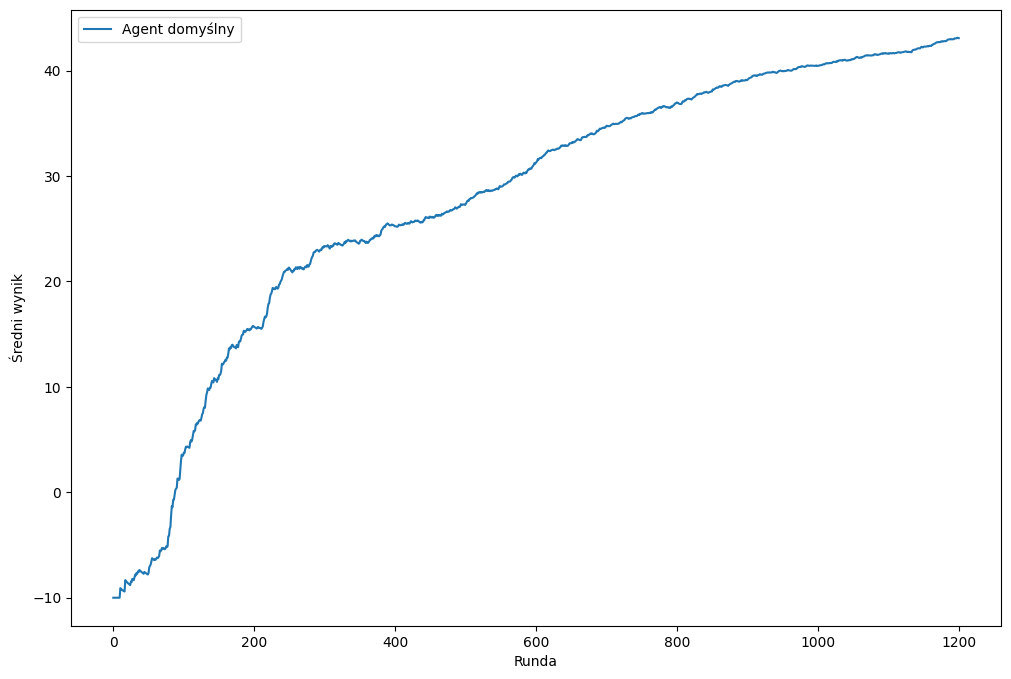

In [12]:
plot_score_increase([default_5x5], ['Agent domyślny'])

## Plansza 30x30

## Wyniki
Poniższa tabela przedstawia średnie i mediany wyników uzyskane przez wytrenowanych agentów (10% ostatnich gier) i człowieka.

In [13]:
compare_stats([default_30x30, default_5x5_on_30x30, human_30x30], ['Agent domyślny', 'Agent domyślny (wytrenowany na planszy 5x5)', 'Człowiek'], is_last_human=True)

,Agent domyślny,Agent domyślny (wytrenowany na planszy 5x5),Człowiek
count,51.000000,50.000000,3.000000
mean,191.960784,182.400000,250.000000
std,113.102071,100.560876,235.796522
min,0.000000,10.000000,50.000000
25%,95.000000,112.500000,120.000000
50%,190.000000,180.000000,190.000000
75%,275.000000,240.000000,350.000000
max,450.000000,420.000000,510.000000


#### Wykres wzrostu wyników

/tmp/ipykernel_190355/2605517962.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


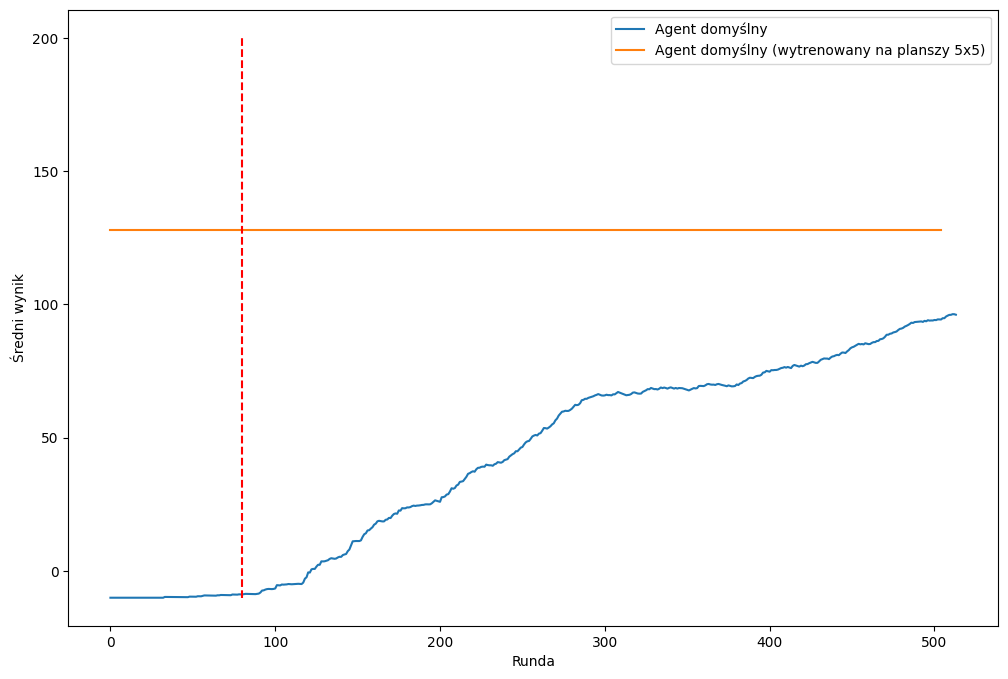

In [34]:
# Ponieważ agent już nie trenuje, ale epsilon nadal nie jest zerowany, konieczne jest wykluczenie rund przed 80
post_epsilon_5x5 = default_5x5_on_30x30.loc[default_5x5_on_30x30['runda'] >= 80]

# Ponieważ agent jest już wytrenowany, lepiej użyć średniej, aby uniknąć odstających wyników.
default_5x5_on_30x30_avg = default_5x5_on_30x30.copy()
avg = post_epsilon_5x5['wynik'].mean()
default_5x5_on_30x30_avg['wynik'] = [avg] * len(default_5x5_on_30x30_avg['wynik'])

fig, ax = plot_score_increase([default_30x30, default_5x5_on_30x30_avg], ['Agent domyślny', 'Agent domyślny (wytrenowany na planszy 5x5)'])
ax.vlines(x=80, ymin=-10, ymax=200, color='red', linestyle='--', label='Wyzerowanie epsilon')
fig.show()

Widać, że ten model, aby nauczyć sie grać na planszy 30x30 potrzebuje rozegrać więcej gier.

Tre

Fakt, że tabela wyników przedstawia lepszy wynik dla modelu 30x30 niż dla modelu 5x5, a przeciwnie wskazuje wykres, świadczy o tym, że w ostatnich 10% gier model trenowany na planszy 30x30 wyprzedził model trenowany na planszy 5x5.

## Adresacja problemów z modelem


### Nawigacja snake'a za pomocą owoców 

Nawigacja snake'a za pomocą owoców prawdopodobnie wynika z faktu, iż owoc nigdy nie znajdzie się poza planszą. Alternatywna przyczyna przegranej - zjedzenie własnego ogona dzieje się na tyle rzadko, że snake traktuje ogon drugorzędnie.


#### Zwiększenie początkowej długości snake'a

Ponieważ problemem jest to, że ogon nie sprawia wystarczająco dużo problemów, moją pierwszą próbą rozwiązania tego problemu było zwiększenie początkowej długości ogona snake'a do 30 pól. Poniżej znajduje się wykres przedstawiający jak wpłyneło to na średni wynik uzyskiwany w następujących rundach.

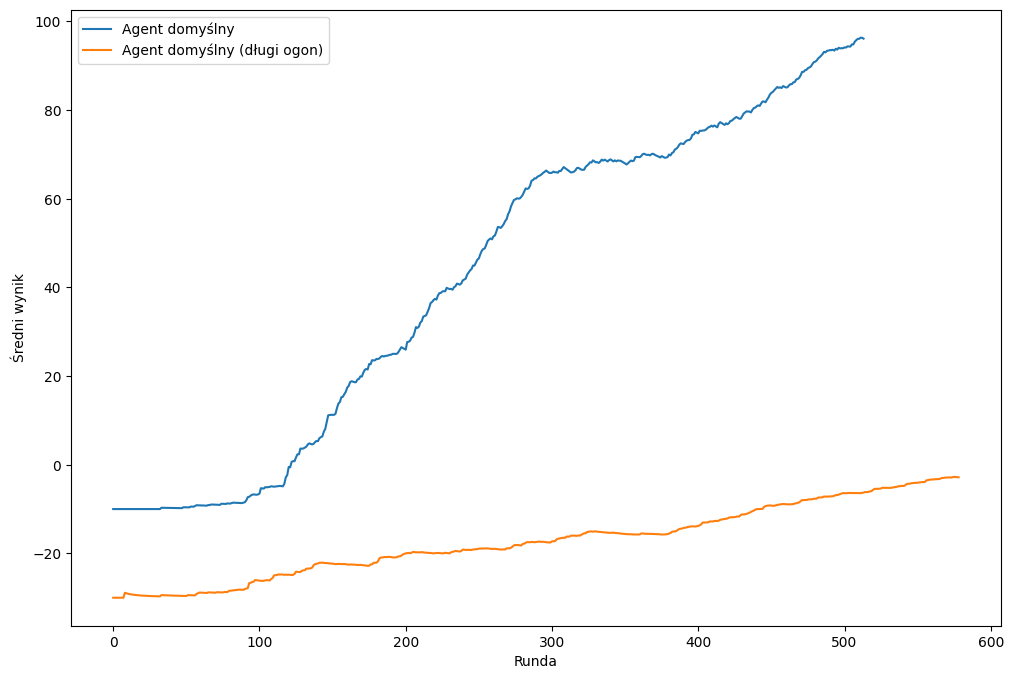

In [15]:
plot_score_increase([default_30x30, default_30x30_long_tail], ['Agent domyślny', 'Agent domyślny (długi ogon)'])